In [83]:
import os 
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_regression, SelectFromModel, mutual_info_regression
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import BinaryEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from datetime import datetime
import matplotlib.pyplot as plt
import json

In [2]:
os.chdir('..')

In [3]:
df = pd.read_csv('ENG_DATA/CLEANED/12-8_Cleaned_df.csv', index_col = [0])

# Fix Missing Data

In [4]:
#fix a bug 
for l in ['charter', 'private', 'public', 'gsRating', 'enrollment']: 
    df[l].fillna(df[l].mean(), inplace=True)

# Add Dates

In [5]:
df["on_market_date"] = df["on_market_date"].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
df["sale_date"] = df["sale_date"].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))

In [6]:
df["on_market_month_year"] = df["on_market_date"].apply(lambda x: x.strftime("%m/%Y"))
df["sale_month_year"] = df["sale_date"].apply(lambda x: x.strftime("%m/%Y"))

# Functions to Test

In [85]:
lr = LinearRegression(normalize=True)
rf = RandomForestRegressor(n_estimators = 20)
kf = KFold(n_splits=5, shuffle=True, random_state=None)
std_scaler = StandardScaler()

In [95]:
def get_score(model, x, y):
    # Split dataset into train and validation subsets:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    print("{}: {}".format(type(model).__name__, model.score(X_test, y_test)))
def get_cvs(model, x, y): 
    scores = cross_val_score(model, x, y, scoring='r2', cv=kf)
    print("R2: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
def get_feature_importance(model, x, y): 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    return pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
def get_coef(model, x, y): 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    return pd.DataFrame(model.coef_, index = X_train.columns, columns=['coef']).sort_values('coef',ascending=False)

In [113]:
x = df.drop(columns = ['sale_price', 'orig_list_price', 'city', 'full_address', 'park_leased'])
y = np.log(df.sale_price)
x_num = x.select_dtypes(include = 'number')
x_cat = x.select_dtypes(exclude = 'number')

# Feature Highlighting & Baseline

In [114]:
# X_train.info()
x_cat.info()
# x_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23720 entries, 0 to 23719
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   street_name           23720 non-null  object        
 1   on_market_date        23720 non-null  datetime64[ns]
 2   sale_date             23720 non-null  datetime64[ns]
 3   zoning                23720 non-null  object        
 4   drive_side            23720 non-null  object        
 5   parking               23720 non-null  object        
 6   shopping              23720 non-null  object        
 7   transportation        23720 non-null  object        
 8   type                  23720 non-null  object        
 9   views                 23720 non-null  object        
 10  neighborhood          23720 non-null  object        
 11  on_market_month_year  23720 non-null  object        
 12  sale_month_year       23720 non-null  object        
dtypes: datetime64[ns

In [11]:
x_cat.nunique()

street_name             1962
on_market_date          3396
sale_date               2655
zoning                    17
drive_side                16
parking                  152
shopping                  14
transportation            16
type                     259
views                   2451
neighborhood             104
on_market_month_year     133
sale_month_year          120
dtype: int64

In [12]:
x_cat.head(5)

,street_name,on_market_date,sale_date,zoning,drive_side,parking,shopping,transportation,type,views,neighborhood,on_market_month_year,sale_month_year
0,El Camino Del Mar,2013-03-14,2013-03-22,RH2,"PVDW,PVSW","ATCH,GARG",4BLK,1BLK,3STR,"PNRM,OCEN,PARK,GRDN",Lincoln Park / Ft. Miley,03/2013,03/2013
1,La Playa St,2017-05-18,2017-08-17,RM1,0,"ATCH,GARG,ATDR,INAC",2BLK,1BLK,0,0,Outer Sunset,05/2017,08/2017
2,48th Ave,2010-06-27,2010-08-20,RH1,"PVDW,PVSW",GARG,3BLK,1BLK,"ATAC,2STR,FIXR","WATR,OCEN,PARK",Sutro Heights,06/2010,08/2010
3,48th Ave,2012-06-07,2012-07-13,OTHR,PVDW,"ATCH,GARG,ATDR,INAC",4BLK,2BLK,3STR,"PNRM,CTYL,OCEN,PARK",Sutro Heights,06/2012,07/2012
4,48th Ave,2018-05-17,2018-06-21,OTHR,0,"ATCH,GARG,ATDR,INAC",3BLK,1BLK,2STR,"PNRM,CTYL,WATR,SFRN,OCEN,PARK,GRDN,TWNP",Sutro Heights,05/2018,06/2018


In [96]:
%%time
get_cvs(lr, x_num, y)
get_score(lr, x_num, y)

R2: 0.851 (+/- 0.012)
LinearRegression: 0.8593629444485931
CPU times: user 632 ms, sys: 72.6 ms, total: 705 ms
Wall time: 394 ms


In [97]:
get_coef(lr, x_num, y).head(10)

,coef
latitude,9.840227
trea,0.781636
baths,0.174038
num_parking,0.071333
on_market_year,0.064909
beds,0.049513
charter,0.044102
embezzlement,0.030783
gambling,0.026934
"sex offenses, non forcible",0.024619


# Feature Elimination
1. Drop Highly Correlated Features
2. Recursively drop Crime and School Features that are not effective

In [115]:
school_features = ["charter", "private", "public", "gsRating", "enrollment"]
crime_features = ["arson", "assault", "bad checks", "bribery", "burglary", "disorderly conduct", "driving under the influence", "drug/narcotic", "drunkenness", "embezzlement", "extortion", "family offenses", "forgery/counterfeiting", "fraud", "gambling", "kidnapping", "larceny/theft", "liquor laws", "loitering", "missing person", "non-criminal", "other offenses", "pornography/obscene mat", "prostitution", "recovered vehicle", "robbery", "runaway", "secondary codes", "sex offenses, forcible", "sex offenses, non forcible", "stolen property", "suicide", "suspicious occ", "trea", "trespass", "vandalism", "vehicle theft", "warrants", "weapon laws", "totalincidents"]

In [117]:
x_sf = x[school_features]
get_score(lr, x_sf, y)
get_score(rf, x_sf, y)

LinearRegression: 0.14754591762864933
RandomForestRegressor: 0.525796528709815


In [118]:
x_cf = x[crime_features]
get_score(lr, x_cf, y)
get_score(rf, x_cf, y)

LinearRegression: 0.5095770296871311
RandomForestRegressor: 0.5961546207044346


In [47]:
get_feature_importance(rf, x_cf, y)

,importance
weapon laws,0.233829
secondary codes,0.156672
prostitution,0.146927
suicide,0.114304
burglary,0.062376
robbery,0.041303
recovered vehicle,0.041036
assault,0.031118
drug/narcotic,0.021947
larceny/theft,0.020186


In [90]:
# classifications
rfecv = RFECV(rf, step=3, min_features_to_select = 4,
              scoring='r2', cv=kf)
rfecv.fit(x_cf, y)
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 10


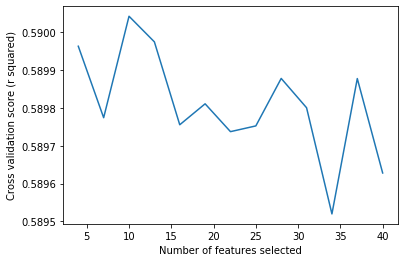

In [91]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r squared)")
plt.plot(range(4, 3*len(rfecv.grid_scores_) + 4, 3), rfecv.grid_scores_)
plt.show()

In [120]:
optimal_crime_features = x_cf.columns[rfecv.support_].to_list()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 40 but corresponding boolean dimension is 5

In [100]:
# classifications
rfecv = RFECV(rf, step=1, min_features_to_select = 1,
              scoring='r2', cv=kf)
rfecv.fit(x_sf, y)
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 5


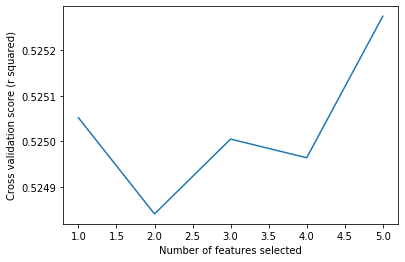

In [102]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (r squared)")
plt.plot(range(1, 1*len(rfecv.grid_scores_) + 1, 1), rfecv.grid_scores_)
plt.show()

In [104]:
get_feature_importance(rf, x_sf, y)

,importance
enrollment,0.392763
gsRating,0.292001
private,0.261197
public,0.034730
charter,0.019310


In [121]:
get_cvs(rf, x_sf["enrollment"].to_frame(), y)
optimal_crime_features.append("enrollment")

R2: 0.526 (+/- 0.014)


In [125]:
cs_to_drop = list(set(school_features + crime_features) - set(optimal_crime_features))

In [127]:
x_cs = x.drop(columns = cs_to_drop)

In [131]:
get_score(lr, x_cs.select_dtypes(include = 'number'), y)
get_score(rf, x_cs.select_dtypes(include = 'number'), y)

LinearRegression: 0.8315186238099188
RandomForestRegressor: 0.9089679208078918


In [134]:
# FROM: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = x_cs.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

In [135]:
x_fe = x_cs.drop(x_cs[to_drop], axis=1).copy()
get_score(lr, x_fe.select_dtypes(include = 'number'), y)
get_score(rf, x_fe.select_dtypes(include = 'number'), y)

LinearRegression: 0.7930486367885938
RandomForestRegressor: 0.9061087012946497


In [27]:
def intoArray(s): 
    print (json.dumps((s.split(','))))

In [33]:
intoArray(s)

["arson", "assault", "bad checks", "bribery", "burglary", "disorderly conduct", "driving under the influence", "drug/narcotic", "drunkenness", "embezzlement", "extortion", "family offenses", "forgery/counterfeiting", "fraud", "gambling", "kidnapping", "larceny/theft", "liquor laws", "loitering", "missing person", "non-criminal", "other offenses", "pornography/obscene mat", "prostitution", "recovered vehicle", "robbery", "runaway", "secondary codes", "\"sex offenses", " forcible\"", "\"sex offenses", " non forcible\"", "stolen property", "suicide", "suspicious occ", "trea", "trespass", "vandalism", "vehicle theft", "warrants", "weapon laws", "totalincidents"]


# Linear Regression Transformation 
1. OneHot Encode variables with comma-seperated features
2. BinaryEncoder for sparse features
3. Ordinal Encoding for Month-Year and Neighborhood

In [188]:
x_lr = x_fe.copy()

In [189]:
x_lr.drop(columns = ['on_market_date', 'sale_date'], inplace=True)

In [190]:
x_lr = x_lr.merge(x_lr['views'].str.get_dummies(sep=',').rename(lambda x: 'views_' + x, axis='columns'), left_index=True, right_index=True)

In [191]:
x_lr = x_lr.merge(x_lr['parking'].str.get_dummies(sep=',').rename(lambda x: 'parking_' + x, axis='columns'), left_index=True, right_index=True)

In [192]:
x_lr = x_lr.merge(x_lr['type'].str.get_dummies(sep=',').rename(lambda x: 'type_' + x, axis='columns'), left_index=True, right_index=True)

In [193]:
x_lr.drop(columns = ['views', 'parking', 'drive_side', 'type'], inplace=True)

In [194]:
x_lr.select_dtypes(exclude = 'number').nunique()

street_name             1962
zoning                    17
shopping                  14
transportation            16
neighborhood             104
on_market_month_year     133
sale_month_year          120
dtype: int64

In [195]:
%%time
get_score(lr, x_lr.select_dtypes(include = 'number'), y)
get_cvs(lr, x_lr.select_dtypes(include = 'number'), y)

LinearRegression: 0.8117587601111074
R2: 0.802 (+/- 0.007)
CPU times: user 680 ms, sys: 74.4 ms, total: 754 ms
Wall time: 430 ms


# Adding Location Variables

In [208]:
x_lc = x_fe.copy()

In [209]:
xy_scaler = std_scaler.fit(x_lc[["latitude","longitude"]])
x_lc[["latitude","longitude"]]=xy_scaler.transform(x_lc[["latitude","longitude"]])

In [210]:
x_lc["rot45latitude"] = .707* x_lc["longitude"] + .707* x_lc["latitude"] 
x_lc["rot45longitude"] = .707* x_lc["longitude"] - .707* x_lc["latitude"]
x_lc["rot30latitude"] = (1.732/2)* x_lc["latitude"] + (1./2)* x_lc["longitude"] 
x_lc["rot30longitude"] = (1.732/2)* x_lc["longitude"] - (1./2)* x_lc["latitude"]
x_lc["rot60latitude"] = (1./2)* x_lc["latitude"] + (1.732/2)* x_lc["longitude"] 
x_lc["rot60longitude"] = (1./2)* x_lc["longitude"] - (1.732/2)* x_lc["latitude"]
x_lc["radial_r"] = np.sqrt( np.power(x_lc["longitude"],2) + np.power(x_lc["latitude"],2))

In [212]:
get_score(rf, x_lc.select_dtypes(include = 'number'), y)

RandomForestRegressor: 0.9078031422919817


# Adding Square Variables

In [213]:
x_lr2 = x_lr.copy()

In [214]:
square_cols_list = []
cols_num = list(set(list(x_lr2.columns)) - set(list(x_lr.columns)).difference(set(list(x_num.columns))))
for col in cols_num: 
    square_cols_list.append(col + "_2") 

In [215]:
x_lr2[square_cols_list] = x_lr2[cols_num].pow(2)

In [225]:
get_score(lr, x_lr2.select_dtypes(include = 'number'), y)

LinearRegression: 0.8643185486945311


In [238]:
cat_drop = x_lr2.select_dtypes(exclude = 'number').columns.to_list()

# Eliminate Features

In [231]:
corr_matrix = x_lr2.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [234]:
x_lr3 = x_lr2.drop(x_lr2[to_drop], axis=1).copy()
get_score(lr, x_lr3.select_dtypes(include = 'number'), y)

LinearRegression: 0.8475813428213197


In [237]:
get_cvs(lr, x_lr3.select_dtypes(include = 'number'), y)

R2: 0.824 (+/- 0.043)


In [239]:
x_lr3.drop(columns = cat_drop, inplace=True)

# Repeat for Log Features 

In [252]:
x_log = x_lr.copy()

In [253]:
log_cols = x_log.select_dtypes(include='float64').columns.tolist()

In [255]:
x_log[log_cols] = np.log(np.abs(x_log[log_cols]).replace(0, np.nan))
x_log.fillna(0, inplace=True)

In [259]:
get_score(lr, x_log.select_dtypes(include = 'number'), y)
get_cvs(lr, x_log.select_dtypes(include = 'number'), y)

LinearRegression: 0.8229650525792356
R2: 0.815 (+/- 0.008)


## Add Square Variables

In [262]:
x_log[square_cols_list] = x_log[cols_num].pow(2)

In [266]:
get_score(lr, x_log.select_dtypes(include = 'number'), y)

LinearRegression: 0.870690626044214


In [267]:
get_cvs(lr, x_log.select_dtypes(include = 'number'), y)

R2: 0.849 (+/- 0.051)


In [269]:
x_log.drop(columns = cat_drop, inplace=True)

# Recursive Feature Elimination

In [243]:
# classifications
rfecv = RFECV(lr, step=3, min_features_to_select = 50,
              scoring='r2', cv=kf)
rfecv.fit(x_lr3, y)
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 75


In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(50, 5*len(rfecv.grid_scores_) + 50, 5), rfecv.grid_scores_)
plt.show()

In [ ]:
x_lr_rfe = x_lr5[x_lr5.columns[rfecv.support_]]

In [ ]:
print("LR r2_score: {:.3f}".format(get_score(lr, x_lr_rfe, y)))

# Export

In [141]:
def export_df(df_, name_):
    month_day = datetime.now().strftime('%m-%d')
    df_.to_csv('ENG_DATA/SELECTED/{}_{}.csv'.format(month_day, name_))

In [251]:
export_df(x_lr3.merge(y, left_index = True, right_index = True), "lr_all")

In [270]:
export_df(x_log.merge(y, left_index = True, right_index = True), "lr_log")

In [249]:
x_fe.drop(columns = cat_drop, inplace=True)

KeyError: "['street_name' 'zoning' 'shopping' 'transportation' 'neighborhood'\n 'on_market_month_year' 'sale_month_year'] not found in axis"

In [250]:
export_df(x_fe.merge(y, left_index=True, right_index=True), "rfe_all")